In [132]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
fulldata = np.load('data/fulldata.npy')

In [7]:
len(fulldata)

4328

In [101]:
num_features = fulldata.shape[1] - 1
num_features = 360 # padded

In [18]:
fulldata[:,:-1][0].shape

(338,)

In [96]:
360 / 2 


180.0

## DataLoader

In [94]:
class TheDataSet(Dataset):
    

    def __init__(self):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.fulldata = np.load('data/fulldata.npy')[:,:-1]
        y, x = self.fulldata.shape
        self.fulldata = np.pad(self.fulldata, ((0, 0),(0,360-x)), 'constant', constant_values=(0,0))

    def __len__(self):
        return len(self.fulldata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.fulldata[idx]
       

## AutoEncoder

In [134]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Linear(in_features=num_features, out_features=num_features // 2 , bias=True),
            nn.ReLU(),
            nn.Linear(in_features=num_features // 2, out_features=num_features // 2, bias=True),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=num_features // 2, out_features=num_features // 2, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=num_features // 2, out_features=num_features, bias=True ),
            #nn.Sigmoid()
            nn.ReLU()
#             nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [122]:
fulldata.shape

(4328, 339)

## Training

In [146]:
def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
#     criterion = nn.MSELoss() # mean square error loss
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # <--
    dataset = TheDataSet()
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    outputs = []
    losses = []
    for epoch in range(num_epochs):
        for data in train_loader:
            recon = model(data.float())
            loss = criterion(recon, data.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        losses.append(float(loss))
        outputs.append((epoch, data, recon),)
    return outputs, losses

In [145]:
model = Autoencoder()
max_epochs = 50
outputs, losses = train(model, num_epochs=max_epochs, batch_size = 32, learning_rate=1e-3)

/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/functional.py:2247: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch:1, Loss:-69067.4844
Epoch:2, Loss:-3207027.2500
Epoch:3, Loss:-21742114.0000
Epoch:4, Loss:-75132384.0000
Epoch:5, Loss:-212468400.0000
Epoch:6, Loss:-386564544.0000
Epoch:7, Loss:-839988736.0000
Epoch:8, Loss:-1202934784.0000
Epoch:9, Loss:-3122966272.0000
Epoch:10, Loss:-3341343488.0000
Epoch:11, Loss:-4652107264.0000
Epoch:12, Loss:-5354986496.0000
Epoch:13, Loss:-7547451904.0000
Epoch:14, Loss:-14747789312.0000
Epoch:15, Loss:-14139575296.0000
Epoch:16, Loss:-18873499648.0000
Epoch:17, Loss:-20532471808.0000
Epoch:18, Loss:-23740262400.0000
Epoch:19, Loss:-31402858496.0000
Epoch:20, Loss:-43489726464.0000
Epoch:21, Loss:-40830091264.0000
Epoch:22, Loss:-49737936896.0000
Epoch:23, Loss:-65710809088.0000
Epoch:24, Loss:-70328696832.0000
Epoch:25, Loss:-73621536768.0000
Epoch:26, Loss:-89101033472.0000
Epoch:27, Loss:-97152393216.0000
Epoch:28, Loss:-157180346368.0000
Epoch:29, Loss:-145525751808.0000
Epoch:30, Loss:-135115194368.0000
Epoch:31, Loss:-165891112960.0000
Epoch:32, 

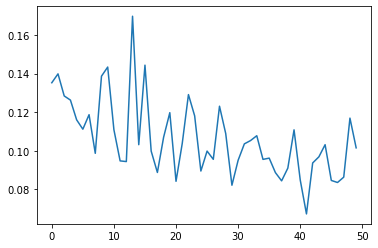

In [141]:
fig = plt.figure()
ax = plt.axes()

# x = np.linspace(0, 10, 1000)
ax.plot(losses);

In [106]:
outputs

[(0,
  tensor([[0.1250, 0.8409, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1250, 0.8409, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1250, 0.8409, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1250, 0.8409, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1250, 0.8409, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1250, 0.8409, 1.8333,  ..., 0.0000, 0.0000, 0.0000]],
         dtype=torch.float64),
  tensor([[0.4998, 0.5199, 0.4721,  ..., 0.5062, 0.4704, 0.5015],
          [0.4957, 0.5167, 0.4710,  ..., 0.5131, 0.4780, 0.4965],
          [0.4925, 0.5210, 0.4680,  ..., 0.5117, 0.4754, 0.4987],
          ...,
          [0.4924, 0.5213, 0.4700,  ..., 0.5101, 0.4731, 0.4977],
          [0.4996, 0.5150, 0.4704,  ..., 0.5145, 0.4760, 0.5003],
          [0.5011, 0.5165, 0.4772,  ..., 0.5141, 0.4840, 0.4923]],
         grad_fn=<SigmoidBackward>)),
 (1,
  tensor([[0.1250, 0.8409, 2.3333,  ..., 0.0000, 0.0000, 0.0000],
          [0.1250, 0.8409, 0.83